In [65]:
from pathlib import Path

In [66]:
import pandas as pd
import seaborn as sns

In [67]:
from lightgbm import LGBMClassifier

import sklearn as sk

from sklearn.model_selection import cross_validate

In [68]:
pd.set_option('display.max_columns', 300)

In [69]:
!ls ../data

sample_submission.csv  test_transaction.csv  train_transaction.csv
test_clean.pkl	       train_clean.pkl
test_identity.csv      train_identity.csv


In [70]:
DATA_DIR = Path('../data')

### Transaction data
- **TransactionDT**: timedelta from a given reference datetime (not an actual timestamp)
- **TransactionAMT**: transaction payment amount in USD
- **ProductCD**: product code, the product for each transaction
- **card1 - card6**: payment card information, such as card type, card category, issue bank, country, etc.
- **addr**: address
- **dist**: distance
- **P_ and (R__) emaildomain**: purchaser and recipient email domain
- **C1-C14**: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
- **D1-D15**: timedelta, such as days between previous transaction, etc.
- **M1-M9**: match, such as names on card and address, etc.
- **Vxxx**: Vesta engineered rich features, including ranking, counting, and other entity relations.

#### Categorical Features:
- ProductCD
- card1 - card6
- addr1, addr2
- Pemaildomain Remaildomain
- M1 - M9

In [71]:
transaction_train = pd.read_csv(DATA_DIR / 'train_transaction.csv')
transaction_sub = pd.read_csv(DATA_DIR / 'test_transaction.csv')

display(transaction_train.head(n=2))
display(transaction_sub.head(n=2))

TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   

   card2  card3       card4  card5   card6  addr1  addr2  dist1  dist2  \
0    NaN  150.0    discover  142.0  credit  315.0   87.0   19.0    NaN   
1  404.0  150.0  mastercard  102.0  credit  325.0   87.0    NaN    NaN   

  P_emaildomain R_emaildomain   C1   C2   C3   C4   C5   C6   C7   C8   C9  \
0           NaN           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0   
1     gmail.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0   

   C10  C11  C12  C13  C14    D1  D2    D3   D4  D5  D6  D7  D8  D9   D10  \
0  0.0  2.0  0.0  1.0  1.0  14.0 NaN  13.0  NaN NaN NaN NaN NaN NaN  13.0   
1  0.0  1.0  0.0  1.0  1.0   0.0 NaN   NaN  0.0 NaN NaN NaN NaN NaN   0.0   

    D11  D12  D13  D14  D15   M1   M2   M3  M4 M5 M6   M7   M8   M9   V1   V2  \
0  13.0  NaN  NaN  NaN  0.0    T    T    T  M2  F  T  NaN  NaN  NaN  1.0  1.0   
1   NaN  NaN  NaN  NaN  0.0  NaN  NaN  NaN  M0  T  T  NaN  NaN  NaN  NaN  NaN   

    V3   V4   V5   V6   V7   V8   V9  V10  V11  V12  V13  V14  V15  V16  V17  \
0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0   
1  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  0.0  0.0  1.0  0.0  0.0  0.0   

   V18  V19  V20  V21  V22  V23  V24  V25  V26  V27  V28  V29  V30  V31  V32  \
0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   

   V33  V34  V35  V36  V37  V38  V39  V40  V41  V42  V43  V44  V45  V46  V47  \
0  0.0  0.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0   

   V48  V49  V50  V51  V52  V53  V54  V55  V56  V57  V58  V59  V60  V61  V62  \
0  NaN  NaN  NaN  NaN  NaN  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0   

   V63  V64  V65  V66  V67  V68  V69  V70  V71  V72  V73  V74  V75  V76  V77  \
0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0   
1  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0   

   V78  V79  V80  V81  V82  V83  V84  V85  V86  V87  V88  V89  V90  V91  V92  \
0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0   
1  1.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0   

   V93  V94  V95  ...  V190  V191  V192  V193  V194  V195  V196  V197  V198  \
0  0.0  0.0  0.0  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1  0.0  0.0  0.0  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

   V199  V200  V201  V202  V203  V204  V205  V206  V207  V208  V209  V210  \
0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

   V211  V212  V213  V214  V215  V216  V217  V218  V219  V220  V221  V222  \
0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

   V223  V224  V225  V226  V227  V228  V229  V230  V231  V232  V233  V234  \
0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

   V235  V236  V237  V238  V239  V240  V241  V242  V243  V244  V245  V246  \
0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

   V247  V248  V249  V250  V251  V252  V253  V254  V255  V256  V257  V258  \
0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   N

TransactionID  TransactionDT  TransactionAmt ProductCD  card1  card2  \
0        3663549       18403224           31.95         W  10409  111.0   
1        3663550       18403263           49.00         W   4272  111.0   

   card3 card4  card5  card6  addr1  addr2  dist1  dist2 P_emaildomain  \
0  150.0  visa  226.0  debit  170.0   87.0    1.0    NaN     gmail.com   
1  150.0  visa  226.0  debit  299.0   87.0    4.0    NaN       aol.com   

  R_emaildomain   C1   C2   C3   C4   C5   C6   C7   C8   C9  C10  C11  C12  \
0           NaN  6.0  6.0  0.0  0.0  3.0  4.0  0.0  0.0  6.0  0.0  5.0  1.0   
1           NaN  3.0  2.0  0.0  0.0  0.0  1.0  0.0  0.0  2.0  0.0  1.0  1.0   

     C13  C14     D1     D2    D3     D4    D5  D6  D7  D8  D9    D10    D11  \
0  115.0  6.0  419.0  419.0  27.0  398.0  27.0 NaN NaN NaN NaN  418.0  203.0   
1   12.0  2.0  149.0  149.0   7.0  634.0   7.0 NaN NaN NaN NaN  231.0  634.0   

   D12  D13  D14    D15 M1 M2 M3   M4   M5 M6   M7   M8   M9   V1   V2   V3  \
0  NaN  NaN  NaN  409.0  T  T  F  NaN  NaN  F    T    T    T  1.0  1.0  1.0   
1  NaN  NaN  NaN  634.0  T  F  F   M0  NaN  F  NaN  NaN  NaN  1.0  1.0  1.0   

    V4   V5   V6   V7   V8   V9  V10  V11  V12  V13  V14  V15  V16  V17  V18  \
0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0   
1  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0   

   V19  V20  V21  V22  V23  V24  V25  V26  V27  V28  V29  V30  V31  V32  V33  \
0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

   V34  V35  V36  V37  V38  V39  V40  V41  V42  V43  V44  V45  V46  V47  V48  \
0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0   
1  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0   

   V49  V50  V51  V52  V53  V54  V55  V56  V57  V58  V59  V60  V61  V62  V63  \
0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0   

   V64  V65  V66  V67  V68  V69  V70  V71  V72  V73  V74  V75  V76  V77  V78  \
0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0   
1  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0   

   V79  V80  V81  V82  V83  V84  V85  V86  V87  V88  V89  V90  V91  V92  V93  \
0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  1.0  1.0  0.0  0.0   
1  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0   

   V94  V95  V96  ...  V190  V191  V192  V193  V194  V195  V196  V197  V198  \
0  0.0  0.0  1.0  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1  0.0  0.0  4.0  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

   V199  V200  V201  V202  V203  V204  V205  V206  V207  V208  V209  V210  \
0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

   V211  V212  V213  V214  V215  V216  V217  V218  V219  V220  V221  V222  \
0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

   V223  V224  V225  V226  V227  V228  V229  V230  V231  V232  V233  V234  \
0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

   V235  V236  V237  V238  V239  V240  V241  V242  V243  V244  V245  V246  \
0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

   V247  V248  V249  V250  V251  V252  V253  V254  V255  V256  V257  V258  \
0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   N

### Identity data

Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions.
They're collected by Vesta’s fraud protection system and digital security partners.
(The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement)

#### Categorical Features:
- DeviceType
- DeviceInfo
- id12 - id38

In [72]:
identity_train = pd.read_csv(DATA_DIR / 'train_identity.csv')
identity_sub = pd.read_csv(DATA_DIR / 'test_identity.csv')

display(identity_train.head(n=2))
display(identity_sub.head(n=2))

TransactionID  id_01    id_02  id_03  id_04  id_05  id_06  id_07  id_08  \
0        2987004    0.0  70787.0    NaN    NaN    NaN    NaN    NaN    NaN   
1        2987008   -5.0  98945.0    NaN    NaN    0.0   -5.0    NaN    NaN   

   id_09  id_10  id_11     id_12  id_13  id_14 id_15     id_16  id_17  id_18  \
0    NaN    NaN  100.0  NotFound    NaN -480.0   New  NotFound  166.0    NaN   
1    NaN    NaN  100.0  NotFound   49.0 -300.0   New  NotFound  166.0    NaN   

   id_19  id_20  id_21  id_22 id_23  id_24  id_25  id_26 id_27 id_28  \
0  542.0  144.0    NaN    NaN   NaN    NaN    NaN    NaN   NaN   New   
1  621.0  500.0    NaN    NaN   NaN    NaN    NaN    NaN   NaN   New   

      id_29        id_30                id_31  id_32      id_33  \
0  NotFound  Android 7.0  samsung browser 6.2   32.0  2220x1080   
1  NotFound   iOS 11.1.2   mobile safari 11.0   32.0   1334x750   

            id_34 id_35 id_36 id_37 id_38 DeviceType  \
0  match_status:2     T     F     T     T     mobile   
1  match_status:1     T     F     F     T     mobile   

                      DeviceInfo  
0  SAMSUNG SM-G892A Build/NRD90M  
1                     iOS Device

TransactionID  id-01     id-02  id-03  id-04  id-05  id-06  id-07  id-08  \
0        3663586  -45.0  280290.0    NaN    NaN    0.0    0.0    NaN    NaN   
1        3663588    0.0    3579.0    0.0    0.0    0.0    0.0    NaN    NaN   

   id-09  id-10  id-11     id-12  id-13  id-14  id-15     id-16  id-17  id-18  \
0    NaN    NaN  100.0  NotFound   27.0    NaN    New  NotFound  225.0   15.0   
1    0.0    0.0  100.0     Found    NaN -300.0  Found     Found  166.0    NaN   

   id-19  id-20  id-21  id-22 id-23  id-24  id-25  id-26 id-27  id-28  \
0  427.0  563.0    NaN    NaN   NaN    NaN    NaN    NaN   NaN    New   
1  542.0  368.0    NaN    NaN   NaN    NaN    NaN    NaN   NaN  Found   

      id-29          id-30                    id-31  id-32     id-33  \
0  NotFound            NaN  chrome 67.0 for android    NaN       NaN   
1     Found  Android 6.0.1  chrome 67.0 for android   24.0  1280x720   

            id-34 id-35 id-36 id-37 id-38 DeviceType  \
0             NaN     F     F     T     F     mobile   
1  match_status:2     T     F     T     T     mobile   

                    DeviceInfo  
0  MYA-L13 Build/HUAWEIMYA-L13  
1         LGLS676 Build/MXB48T

Id columns are named inconsistently. Lets fix it.

In [73]:
identity_sub.columns = [col.replace('-', '_') for col in identity_sub.columns]
identity_sub.head(n=2)

TransactionID  id_01     id_02  id_03  id_04  id_05  id_06  id_07  id_08  \
0        3663586  -45.0  280290.0    NaN    NaN    0.0    0.0    NaN    NaN   
1        3663588    0.0    3579.0    0.0    0.0    0.0    0.0    NaN    NaN   

   id_09  id_10  id_11     id_12  id_13  id_14  id_15     id_16  id_17  id_18  \
0    NaN    NaN  100.0  NotFound   27.0    NaN    New  NotFound  225.0   15.0   
1    0.0    0.0  100.0     Found    NaN -300.0  Found     Found  166.0    NaN   

   id_19  id_20  id_21  id_22 id_23  id_24  id_25  id_26 id_27  id_28  \
0  427.0  563.0    NaN    NaN   NaN    NaN    NaN    NaN   NaN    New   
1  542.0  368.0    NaN    NaN   NaN    NaN    NaN    NaN   NaN  Found   

      id_29          id_30                    id_31  id_32     id_33  \
0  NotFound            NaN  chrome 67.0 for android    NaN       NaN   
1     Found  Android 6.0.1  chrome 67.0 for android   24.0  1280x720   

            id_34 id_35 id_36 id_37 id_38 DeviceType  \
0             NaN     F     F     T     F     mobile   
1  match_status:2     T     F     T     T     mobile   

                    DeviceInfo  
0  MYA-L13 Build/HUAWEIMYA-L13  
1         LGLS676 Build/MXB48T

### Merge transaction and identity tables

In [74]:
df_train = transaction_train.merge(identity_train, on='TransactionID', how='left')
df_sub = transaction_sub.merge(identity_sub, on='TransactionID', how='left')

display(df_train.head(n=2))
display(df_sub.head(n=2))

TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   

   card2  card3       card4  card5   card6  addr1  addr2  dist1  dist2  \
0    NaN  150.0    discover  142.0  credit  315.0   87.0   19.0    NaN   
1  404.0  150.0  mastercard  102.0  credit  325.0   87.0    NaN    NaN   

  P_emaildomain R_emaildomain   C1   C2   C3   C4   C5   C6   C7   C8   C9  \
0           NaN           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0   
1     gmail.com           NaN  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0   

   C10  C11  C12  C13  C14    D1  D2    D3   D4  D5  D6  D7  D8  D9   D10  \
0  0.0  2.0  0.0  1.0  1.0  14.0 NaN  13.0  NaN NaN NaN NaN NaN NaN  13.0   
1  0.0  1.0  0.0  1.0  1.0   0.0 NaN   NaN  0.0 NaN NaN NaN NaN NaN   0.0   

    D11  D12  D13  D14  D15   M1   M2   M3  M4 M5 M6   M7   M8   M9   V1   V2  \
0  13.0  NaN  NaN  NaN  0.0    T    T    T  M2  F  T  NaN  NaN  NaN  1.0  1.0   
1   NaN  NaN  NaN  NaN  0.0  NaN  NaN  NaN  M0  T  T  NaN  NaN  NaN  NaN  NaN   

    V3   V4   V5   V6   V7   V8   V9  V10  V11  V12  V13  V14  V15  V16  V17  \
0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0   
1  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  0.0  0.0  1.0  0.0  0.0  0.0   

   V18  V19  V20  V21  V22  V23  V24  V25  V26  V27  V28  V29  V30  V31  V32  \
0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   

   V33  V34  V35  V36  V37  V38  V39  V40  V41  V42  V43  V44  V45  V46  V47  \
0  0.0  0.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0   

   V48  V49  V50  V51  V52  V53  V54  V55  V56  V57  V58  V59  V60  V61  V62  \
0  NaN  NaN  NaN  NaN  NaN  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0   

   V63  V64  V65  V66  V67  V68  V69  V70  V71  V72  V73  V74  V75  V76  V77  \
0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0   
1  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0   

   V78  V79  V80  V81  V82  V83  V84  V85  V86  V87  V88  V89  V90  V91  V92  \
0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0   
1  1.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0   

   V93  V94  V95  ...  V230  V231  V232  V233  V234  V235  V236  V237  V238  \
0  0.0  0.0  0.0  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1  0.0  0.0  0.0  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

   V239  V240  V241  V242  V243  V244  V245  V246  V247  V248  V249  V250  \
0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

   V251  V252  V253  V254  V255  V256  V257  V258  V259  V260  V261  V262  \
0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

   V263  V264  V265  V266  V267  V268  V269  V270  V271  V272  V273  V274  \
0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

   V275  V276  V277  V278  V279  V280  V281  V282  V283  V284  V285  V286  \
0   NaN   NaN   NaN   NaN   0.0   0.0   0.0   1.0   1.0   0.0   0.0   0.0   
1   NaN   NaN   NaN   NaN   0.0   0.0   0.0   1.0   1.0   0.0   0.0   0.0   

   V287  V288  V289  V290  V291  V292  V293  V294  V295  V296  V297  V298  \
0   0.0   0.0   0.0   1.0   1.0   1.0   0.0   1.0   0.0   0.0   0.0   0.0   
1   0.0   0.0   0.0   1.0   1.0   1.0   0.0   0.0   0.0   0.0   0.0   0

TransactionID  TransactionDT  TransactionAmt ProductCD  card1  card2  \
0        3663549       18403224           31.95         W  10409  111.0   
1        3663550       18403263           49.00         W   4272  111.0   

   card3 card4  card5  card6  addr1  addr2  dist1  dist2 P_emaildomain  \
0  150.0  visa  226.0  debit  170.0   87.0    1.0    NaN     gmail.com   
1  150.0  visa  226.0  debit  299.0   87.0    4.0    NaN       aol.com   

  R_emaildomain   C1   C2   C3   C4   C5   C6   C7   C8   C9  C10  C11  C12  \
0           NaN  6.0  6.0  0.0  0.0  3.0  4.0  0.0  0.0  6.0  0.0  5.0  1.0   
1           NaN  3.0  2.0  0.0  0.0  0.0  1.0  0.0  0.0  2.0  0.0  1.0  1.0   

     C13  C14     D1     D2    D3     D4    D5  D6  D7  D8  D9    D10    D11  \
0  115.0  6.0  419.0  419.0  27.0  398.0  27.0 NaN NaN NaN NaN  418.0  203.0   
1   12.0  2.0  149.0  149.0   7.0  634.0   7.0 NaN NaN NaN NaN  231.0  634.0   

   D12  D13  D14    D15 M1 M2 M3   M4   M5 M6   M7   M8   M9   V1   V2   V3  \
0  NaN  NaN  NaN  409.0  T  T  F  NaN  NaN  F    T    T    T  1.0  1.0  1.0   
1  NaN  NaN  NaN  634.0  T  F  F   M0  NaN  F  NaN  NaN  NaN  1.0  1.0  1.0   

    V4   V5   V6   V7   V8   V9  V10  V11  V12  V13  V14  V15  V16  V17  V18  \
0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0   
1  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0   

   V19  V20  V21  V22  V23  V24  V25  V26  V27  V28  V29  V30  V31  V32  V33  \
0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

   V34  V35  V36  V37  V38  V39  V40  V41  V42  V43  V44  V45  V46  V47  V48  \
0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0   
1  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0   

   V49  V50  V51  V52  V53  V54  V55  V56  V57  V58  V59  V60  V61  V62  V63  \
0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0   

   V64  V65  V66  V67  V68  V69  V70  V71  V72  V73  V74  V75  V76  V77  V78  \
0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0   
1  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0   

   V79  V80  V81  V82  V83  V84  V85  V86  V87  V88  V89  V90  V91  V92  V93  \
0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  1.0  1.0  0.0  0.0   
1  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0   

   V94  V95  V96  ...  V230  V231  V232  V233  V234  V235  V236  V237  V238  \
0  0.0  0.0  1.0  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1  0.0  0.0  4.0  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

   V239  V240  V241  V242  V243  V244  V245  V246  V247  V248  V249  V250  \
0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

   V251  V252  V253  V254  V255  V256  V257  V258  V259  V260  V261  V262  \
0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

   V263  V264  V265  V266  V267  V268  V269  V270  V271  V272  V273  V274  \
0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

   V275  V276  V277  V278  V279  V280  V281  V282  V283  V284  V285  V286  \
0   NaN   NaN   NaN   NaN   0.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0   
1   NaN   NaN   NaN   NaN   0.0   1.0   0.0   0.0   0.0   0.0   4.0   0.0   

   V287  V288  V289  V290  V291  V292  V293  V294  V295  V296  V297  V298  \
0   0.0   0.0   0.0   1.0   1.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   
1   1.0   0.0   0.0   1.0   1.0   1.0   0.0   0.0   0.0   0.0   0.0   0

In [75]:
del transaction_train
del transaction_sub

del identity_train
del identity_sub

import gc; gc.collect()

28

### Data inspection

In [76]:
len(df_train.TransactionID.unique()) == len(df_train)

True

As expected transaction id is unique for each transaction.

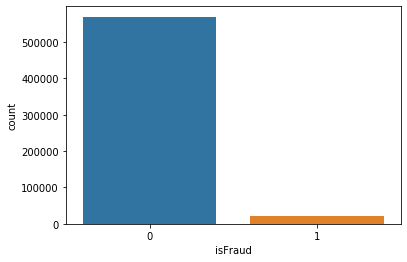

In [77]:
sns.countplot(x='isFraud', data=df_train)

Target variable has very unbalanced distribution.

### Feature selection

First lets drop features with 85% empty values.

In [78]:
def get_features_exceding_nans_threshold(df, threshold):
    return df.columns[df.isna().sum() / len(df) > threshold].to_list()

In [79]:
features_to_drop = set()

for df in [df_train, df_sub]:
    features_to_drop.update(
        get_features_exceding_nans_threshold(df, threshold=0.85)
    )
    
features_to_drop = list(sorted(features_to_drop))

print('Features to drop:')
print(', '.join(sorted(features_to_drop)))

Features to drop:
D12, D13, D14, D6, D7, D8, D9, V138, V139, V140, V141, V142, V143, V144, V145, V146, V147, V148, V149, V150, V151, V152, V153, V154, V155, V156, V157, V158, V159, V160, V161, V162, V163, V164, V165, V166, V322, V323, V324, V325, V326, V327, V328, V329, V330, V331, V332, V333, V334, V335, V336, V337, V338, V339, dist2, id_03, id_04, id_07, id_08, id_09, id_10, id_14, id_18, id_21, id_22, id_23, id_24, id_25, id_26, id_27, id_30, id_32, id_33, id_34


In [80]:
df_train.drop(columns=features_to_drop, inplace=True)
df_sub.drop(columns=features_to_drop, inplace=True)

Lets divide the variables into continous and categorical:

**continuous**:
- TransactionDT
- TransactionAmt
- dist1
- dist2
- C1-C14
- D1-D15
- V1-339
- id01-10

**categorical**:
- card1-6
- addr1
- addr2
- P_emaildomain
- R_emaildomain
- M1-9

In [81]:
continuous_vars = [
    'TransactionAmt',
    'dist1',
    'dist2',
    *(f'C{i}' for i in range(1, 15)),
    *(f'D{i}' for i in range(1, 16)),
    *(f'V{i}' for i in range(1, 340)),
    *(f'id_0{i}' for i in range(1, 10)),
    'id_10',
]
'; '.join(continuous_vars)

'TransactionAmt; dist1; dist2; C1; C2; C3; C4; C5; C6; C7; C8; C9; C10; C11; C12; C13; C14; D1; D2; D3; D4; D5; D6; D7; D8; D9; D10; D11; D12; D13; D14; D15; V1; V2; V3; V4; V5; V6; V7; V8; V9; V10; V11; V12; V13; V14; V15; V16; V17; V18; V19; V20; V21; V22; V23; V24; V25; V26; V27; V28; V29; V30; V31; V32; V33; V34; V35; V36; V37; V38; V39; V40; V41; V42; V43; V44; V45; V46; V47; V48; V49; V50; V51; V52; V53; V54; V55; V56; V57; V58; V59; V60; V61; V62; V63; V64; V65; V66; V67; V68; V69; V70; V71; V72; V73; V74; V75; V76; V77; V78; V79; V80; V81; V82; V83; V84; V85; V86; V87; V88; V89; V90; V91; V92; V93; V94; V95; V96; V97; V98; V99; V100; V101; V102; V103; V104; V105; V106; V107; V108; V109; V110; V111; V112; V113; V114; V115; V116; V117; V118; V119; V120; V121; V122; V123; V124; V125; V126; V127; V128; V129; V130; V131; V132; V133; V134; V135; V136; V137; V138; V139; V140; V141; V142; V143; V144; V145; V146; V147; V148; V149; V150; V151; V152; V153; V154; V155; V156; V157; V158; V1

In [82]:
categorical_vars = [
    'ProductCD',
    'DeviceType',
    *(f'card{i}' for i in range(1, 7)),
    *(f'M{i}' for i in range(1, 10)),
    *(f'id_{i}' for i in range(12, 39)),
    'addr1', 
    'addr2',
    'P_emaildomain',
    'R_emaildomain'
]
'; '.join(categorical_vars)

'ProductCD; DeviceType; card1; card2; card3; card4; card5; card6; M1; M2; M3; M4; M5; M6; M7; M8; M9; id_12; id_13; id_14; id_15; id_16; id_17; id_18; id_19; id_20; id_21; id_22; id_23; id_24; id_25; id_26; id_27; id_28; id_29; id_30; id_31; id_32; id_33; id_34; id_35; id_36; id_37; id_38; addr1; addr2; P_emaildomain; R_emaildomain'

Lets inspect the number of unique values among categorical variables.

ProductCD  card1  card2  card3  card4  card5  card6  addr1  addr2  \
0          5  13553    500    114      4    119      4    332     74   

   P_emaildomain  R_emaildomain  M1  M2  M3  M4  M5  M6  M7  M8  M9  id_12  \
0             59             60   2   2   2   3   2   2   2   2   2      2   

   id_13  id_15  id_16  id_17  id_19  id_20  id_28  id_29  id_31  id_35  \
0     54      3      2    104    522    394      2      2    130      2   

   id_36  id_37  id_38  DeviceType  
0      2      2      2           2

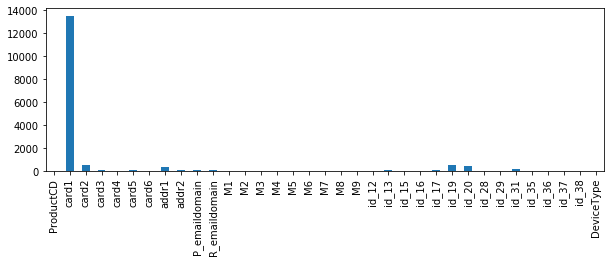

In [83]:
cat_occurences = {col: values.nunique() for col, values in df_train.iteritems()
                  if col in categorical_vars and col not in features_to_drop}

display(pd.DataFrame(cat_occurences, index=[0]))
pd.Series(cat_occurences).plot.bar(figsize=(10, 3))

**card1** variable has lots of unique values. That is why we are going to mean encode it.
Lets look at the other variables:

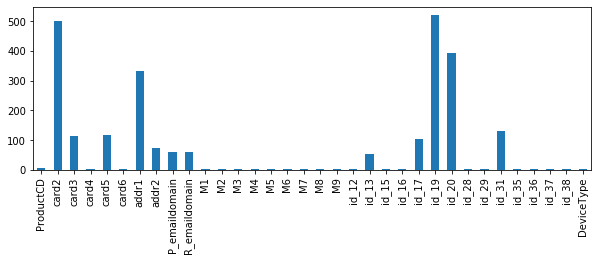

In [84]:
cat_occurences.pop('card1')
pd.Series(cat_occurences).plot.bar(figsize=(10, 3))

### Feature engineering

In [85]:
def mean_encode(df, col, target, encoding=None):
    if encoding is None:
        encoding = df.groupby(col)[target].mean()
    return df[col].map(encoding), encoding

In [86]:
df_train['card1MeanEncoded'], encoding = mean_encode(df_train, 'card1', 'isFraud')
df_sub['card1MeanEncoded'] = df_sub['card1'].map(encoding)

df_train['card2MeanEncoded'], encoding = mean_encode(df_train, 'card2', 'isFraud')
df_sub['card2MeanEncoded'] = df_sub['card2'].map(encoding)

continuous_vars.extend(['card1MeanEncoded', 'card2MeanEncoded'])

In [87]:
mean_transaction_amt = df_train.TransactionAmt.mean()

df_train['TransactionAmtMeanDiff'] = df_train.TransactionAmt - mean_transaction_amt
df_sub['TransactionAmtMeanDiff'] = df_sub.TransactionAmt - mean_transaction_amt

continuous_vars.append('TransactionAmtMeanDiff')

In [88]:
median_transaction_amt = df_train.TransactionAmt.median()

df_train['TransactionAmtMedianDiff'] = df_train.TransactionAmt - median_transaction_amt
df_sub['TransactionAmtMedianDiff'] = df_sub.TransactionAmt - median_transaction_amt

continuous_vars.append('TransactionAmtMedianDiff')

In [89]:
df_train['TransactionAmtHasDecimal'] = df_train.TransactionAmt % 1 > 0
df_sub['TransactionAmtHasDecimal'] = df_train.TransactionAmt % 1 > 0

categorical_vars.append('TransactionAmtHasDecimal')

In [90]:
df_train.P_emaildomain.unique()

array([nan, 'gmail.com', 'outlook.com', 'yahoo.com', 'mail.com',
       'anonymous.com', 'hotmail.com', 'verizon.net', 'aol.com', 'me.com',
       'comcast.net', 'optonline.net', 'cox.net', 'charter.net',
       'rocketmail.com', 'prodigy.net.mx', 'embarqmail.com', 'icloud.com',
       'live.com.mx', 'gmail', 'live.com', 'att.net', 'juno.com',
       'ymail.com', 'sbcglobal.net', 'bellsouth.net', 'msn.com', 'q.com',
       'yahoo.com.mx', 'centurylink.net', 'servicios-ta.com',
       'earthlink.net', 'hotmail.es', 'cfl.rr.com', 'roadrunner.com',
       'netzero.net', 'gmx.de', 'suddenlink.net', 'frontiernet.net',
       'windstream.net', 'frontier.com', 'outlook.es', 'mac.com',
       'netzero.com', 'aim.com', 'web.de', 'twc.com', 'cableone.net',
       'yahoo.fr', 'yahoo.de', 'yahoo.es', 'sc.rr.com', 'ptd.net',
       'live.fr', 'yahoo.co.uk', 'hotmail.fr', 'hotmail.de',
       'hotmail.co.uk', 'protonmail.com', 'yahoo.co.jp'], dtype=object)

### Encode categorical variables

In [91]:
for col in categorical_vars:
    if col in df_train.columns:
        le = sk.preprocessing.LabelEncoder()
        le.fit(
            list(df_train[col].astype(str).values) + list(df_sub[col].astype(str).values)
        )
        
        df_train[col] = le.transform(list(df_train[col].astype(str).values))
        df_sub[col] = le.transform(list(df_sub[col].astype(str).values))

In [92]:
for col in continuous_vars:
    if col in df_train.columns:
        na_col_fill = df_train[col].min() - 1
        df_train[col].fillna(na_col_fill, inplace=True)
        df_sub[col].fillna(na_col_fill, inplace=True)  

In [93]:
all_vars = set(df_train.columns) & (set(continuous_vars) | set(categorical_vars))

In [94]:
unused_cols = list(set(df_train.columns) - (all_vars | {'isFraud', 'TransactionID'}))
unused_cols

['DeviceInfo', 'TransactionDT', 'id_11']

In [95]:
df_train.drop(columns=unused_cols, inplace=True)
df_sub.drop(columns=unused_cols, inplace=True)

In [101]:
from utils import reduce_mem_usage

df_train = reduce_mem_usage(df_train)
df_sub = reduce_mem_usage(df_sub)

Iter columns: 100%|██████████| 361/361 [05:46<00:00,  1.04it/s]

Mem. usage decreased to 1280.04 Mb (8.5% reduction)


In [103]:
df_train.to_pickle(DATA_DIR / 'train_clean.pkl')
df_sub.to_pickle(DATA_DIR / 'test_clean.pkl')

In [113]:
variables = {
    'continuous': sorted(set(continuous_vars) & set(df_train.columns)),
    'categorical': sorted(set(categorical_vars) & set(df_train.columns)),
}

with open( DATA_DIR / 'variables-type.json', 'w') as fp:
    import json
    json.dump(variables, fp)

In [56]:
x = df_train[sorted(all_vars)]
x.head()

C1  C10  C11  C12   C13  C14   C2   C3   C4   C5   C6   C7   C8   C9  \
0  1.0  0.0  2.0  0.0   1.0  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0   
1  1.0  0.0  1.0  0.0   1.0  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0   
2  1.0  0.0  1.0  0.0   1.0  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0   
3  2.0  0.0  1.0  0.0  25.0  1.0  5.0  0.0  0.0  0.0  4.0  0.0  0.0  1.0   
4  1.0  1.0  1.0  0.0   1.0  1.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0   

      D1   D10    D11    D15     D2    D3     D4   D5  DeviceType  M1  M2  M3  \
0   14.0  13.0   13.0    0.0   -1.0  13.0 -123.0 -1.0           2   1   1   1   
1    0.0   0.0  -54.0    0.0   -1.0  -1.0    0.0 -1.0           2   2   2   2   
2    0.0   0.0  315.0  315.0   -1.0  -1.0    0.0 -1.0           2   1   1   1   
3  112.0  84.0  -54.0  111.0  112.0   0.0   94.0  0.0           2   2   2   2   
4    0.0  -1.0  -54.0  -84.0   -1.0  -1.0 -123.0 -1.0           1   2   2   2   

   M4  M5  M6  M7  M8  M9  P_emaildomain  ProductCD  R_emaildomain  \
0   2   0   1   2   2   2             32          4             32   
1   0   1   1   2   2   2             16          4             32   
2   0   0   0   0   0   0             36          4             32   
3   0   1   0   2   2   2             55          4             32   
4   3   2   2   2   2   2             16          1             32   

   TransactionAmt  TransactionAmtHasDecimal  TransactionAmtMeanDiff  \
0            68.5                         1              -66.527176   
1            29.0                         0             -106.027176   
2            59.0                         0              -76.027176   
3            50.0                         0              -85.027176   
4            50.0                         0              -85.027176   

   TransactionAmtMedianDiff   V1  V10  V100  V101  V102  V103  V104  V105  \
0                    -0.269  1.0  0.0   0.0   0.0   1.0   0.0   0.0   0.0   
1                   -39.769 -1.0 -1.0   0.0   0.0   0.0   0.0   0.0   0.0   
2                    -9.769  1.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0   
3                   -18.769 -1.0 -1.0   4.0   1.0  38.0  24.0   0.0   0.0   
4                   -18.769 -1.0 -1.0   0.0   0.0   0.0   0.0   0.0   0.0   

   V106  V107  V108  V109  V11  V110  V111  V112  V113  V114  V115  V116  \
0   0.0   1.0   1.0   1.0  0.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
1   0.0   1.0   1.0   1.0 -1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
2   0.0   1.0   1.0   1.0  0.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
3   0.0   1.0   1.0   1.0 -1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
4   0.0   1.0   1.0   1.0 -1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   

   V117  V118  V119  V12  V120  V121  V122  V123  V124  V125  V126    V127  \
0   1.0   1.0   1.0  1.0   1.0   1.0   1.0   1.0   1.0   1.0   0.0   117.0   
1   1.0   1.0   1.0  0.0   1.0   1.0   1.0   1.0   1.0   1.0   0.0     0.0   
2   1.0   1.0   1.0  1.0   1.0   1.0   1.0   1.0   1.0   1.0   0.0     0.0   
3   1.0   1.0   1.0  1.0   1.0   1.0   1.0   1.0   1.0   1.0  50.0  1758.0   
4   1.0   1.0   1.0 -1.0   1.0   1.0   1.0   1.0   1.0   1.0   0.0     0.0   

    V128  V129  V13   V130   V131  V132    V133   V134  V135  V136  V137  V14  \
0    0.0   0.0  1.0    0.0    0.0   0.0   117.0    0.0   0.0   0.0   0.0  1.0   
1    0.0   0.0  0.0    0.0    0.0   0.0     0.0    0.0   0.0   0.0   0.0  1.0   
2    0.0   0.0  1.0    0.0    0.0   0.0     0.0    0.0   0.0   0.0   0.0  1.0   
3  925.0   0.0  1.0  354.0  135.0  50.0  1404.0  790.0   0.0   0.0   0.0  1.0   
4    0.0   0.0 -1.0    0.0    0.0   0.0     0.0    0.0   0.0   0.0   0.0 -1.0   

   V15  V16  V167  V168  V169  V17  V170  V171  V172  V173  V174  V175  V176  \
0  0.0  0.0  -1.0  -1.0  -1.0  0.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0   
1  0.0  0.0  -1.0  -1.0  -1.0  0.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0   
2  0.0  0.0  -1.0  -1.0  -1.0  0.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0   
3  0.0  0.0  -1.

In [57]:
y = df_train.isFraud
y.head()

0    0
1    0
2    0
3    0
4    0
Name: isFraud, dtype: int8

In [58]:
clf = LGBMClassifier(
    n_estimators=100,
    
    objective='binary',
    metric='auc',
    
    random_state=420,
    
    colsample_bytree=0.9,
    subsample=0.9,
    subsample_freq=1,
    
    reg_lambda=0.3,
    reg_alpha=0.3,
    
    max_depth=10,
    num_leaves=250,
    min_child_samples=80
)

In [59]:
scores = cross_validate(clf, x, y, cv=3, scoring=['f1_macro', 'recall_macro', 'precision_macro', 'accuracy', 'roc_auc'])
scores = pd.DataFrame.from_dict(scores)
scores

fit_time  score_time  test_f1_macro  test_recall_macro  \
0  178.345728    3.972808       0.771314           0.709415   
1   36.178352    2.164516       0.791194           0.727280   
2   34.737396    2.226984       0.771852           0.709033   

   test_precision_macro  test_accuracy  test_roc_auc  
0              0.893650       0.976276      0.930910  
1              0.912734       0.978079      0.944093  
2              0.897533       0.976428      0.939089

In [60]:
scores.mean()

fit_time                83.087159
score_time               2.788103
test_f1_macro            0.778120
test_recall_macro        0.715243
test_precision_macro     0.901306
test_accuracy            0.976928
test_roc_auc             0.938031
dtype: float64

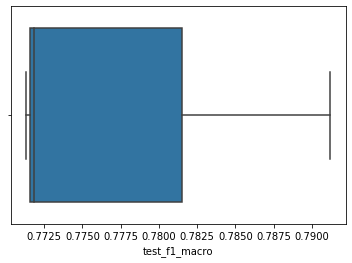

In [61]:
sns.boxplot(x='test_f1_macro', data=scores)

In [62]:
clf.fit(x, y)
probs = clf.predict_proba(df_sub[all_vars])

In [98]:
outcome_df = pd.DataFrame(df_sub.TransactionID)
outcome_df['isFraud'] = probs[:, 1]
outcome_df.head()

TransactionID   isFraud
0        3663549  0.000199
1        3663550  0.000167
2        3663551  0.000214
3        3663552  0.000286
4        3663553  0.000196

In [99]:
outcome_df.to_csv('submission.csv', index=False)

### Show feature importances

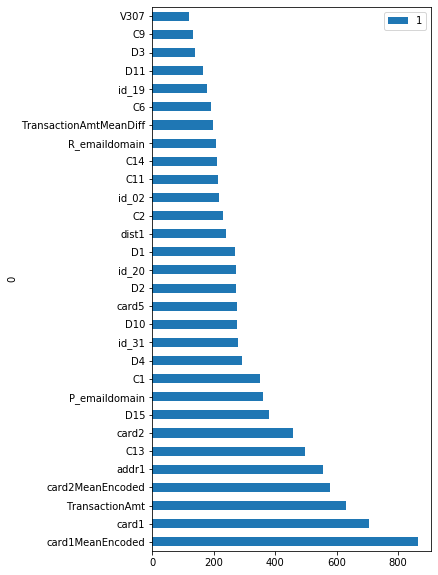

In [100]:
pd.DataFrame(
    sorted(zip(x.columns, clf.feature_importances_), key=lambda item: item[1], reverse=True)[:30]
).set_index(0).plot.barh(figsize=(5, 10))